In [1]:
import hmftpy as hmf
from hmftpy.plaquettes.triangular import plaq12, plaq12z, plaq9p, plaq9d, plaq3, plaq7, plaq19, test_bonds
from hmftpy.operators import mf_ops, inner_hamiltonian, periodic_hamiltonian
from hmftpy import do_hmft
from hmftpy.plot_spins import draw_tri_lattice, draw_cluster, plot_spins
from quspin.basis import spin_basis_1d
from quspin.operators import quantum_operator
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
maxit = 50

# $J_1$-$J_2$-$J_3$ model with 7 sites

In [2]:
def ni_op(plaq, basis):
    A, B, C = plaq['n_nearest_sublattice']
    a_op = quantum_operator({'static': [['x', [[1/len(A), j] for j in A]]]}, basis=basis, check_symm=False, check_herm=False)
    b_op = quantum_operator({'static': [['x', [[-0.5/len(B), j] for j in B]],
                                        ['y', [[0.5*np.sqrt(3)/len(B), j] for j in B]]]}, basis=basis, check_symm=False, check_herm=False)
    c_op = quantum_operator({'static': [['x', [[-0.5/len(C), j] for j in C]],
                                        ['y', [[-0.5*np.sqrt(3)/len(C), j] for j in C]]]}, basis=basis, check_symm=False, check_herm=False)
    return a_op + b_op + c_op

def ms_ops(plaq, basis, d='x'):
    xs = plaq['x_stripes']
    ys = plaq['y_stripes']
    zs = plaq['z_stripes']
    xs_op = quantum_operator({'static': [[d, [[1/len(xs[0]), j] for j in xs[0]] + [[-1/len(xs[1]), j] for j in xs[1]]
                                         ]]}, basis=basis, check_symm=False, check_herm=False)
    ys_op = quantum_operator({'static': [[d, [[1/len(ys[0]), j] for j in ys[0]] + [[-1/len(ys[1]), j] for j in ys[1]]
                                         ]]}, basis=basis, check_symm=False, check_herm=False)
    zs_op = quantum_operator({'static': [[d, [[1/len(zs[0]), j] for j in zs[0]] + [[-1/len(zs[1]), j] for j in zs[1]]
                                         ]]}, basis=basis, check_symm=False, check_herm=False)
    return xs_op, ys_op, zs_op

In [3]:
plaq = plaq7
basis = spin_basis_1d(7, pauli=0)
ops = hmf.operators.mf_ops(plaq, basis)
steps = 50

J3s = [0, 0.1, 0.5, 0.9, 1, 1.1]

energies = {J3: np.zeros(steps) for J3 in J3s}

Ms_ops_x = ms_ops(plaq, basis, d='x')
Ms_ops_y = ms_ops(plaq, basis, d='y')
Mxs = {J3: np.zeros(steps) for J3 in J3s}
Mys = {J3: np.zeros(steps) for J3 in J3s}
Mzs = {J3: np.zeros(steps) for J3 in J3s}

Ni_ops = ni_op(plaq, basis)
Ni = {J3: np.zeros(steps) for J3 in J3s}

degens = {J3: np.zeros(steps) for J3 in J3s}

alphas = np.linspace(0, 3, steps)

In [4]:
for J3 in J3s:
    for i, alpha in enumerate(tqdm(alphas)):
        interactions = {'nearest': {'xx': 1, 'yy': 1},
                        'n_nearest': {'xx': np.sqrt(3)**-alpha, 'yy': np.sqrt(3)**-alpha},
                        'n_n_nearest': {'xx': J3*(2**-alpha), 'yy': J3*(2**-alpha)}}
        Hi = inner_hamiltonian(plaq, interactions, basis)
        e, v = Hi.eigh()
        ei = np.argmin(e)

        energies[J3][i] = np.min(e)
        degens[J3][i] = len(e[np.abs(e-np.min(e)) < 10**-10])
        v0 = v[:,ei]

        Ni[J3][i] = np.real(np.vdot(v0, Ni_ops.dot(Ni_ops.dot(v0))))

        Mxs[J3][i] = np.real(np.vdot(v0, Ms_ops_x[0].dot(Ms_ops_x[0].dot(v0))))
        Mys[J3][i] = np.real(np.vdot(v0, Ms_ops_x[1].dot(Ms_ops_x[1].dot(v0))))
        Mzs[J3][i] = np.real(np.vdot(v0, Ms_ops_x[2].dot(Ms_ops_x[2].dot(v0))))

100%|██████████| 50/50 [00:05<00:00,  9.76it/s]


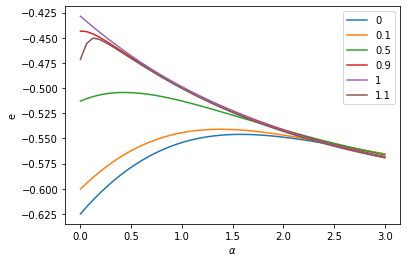

In [5]:
for J3 in J3s:
    plt.plot(alphas, energies[J3]/7, label=J3)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('e')
plt.show()

Text(0, 0.5, '$N_I$')

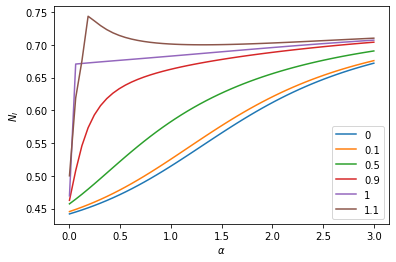

In [6]:
for J3 in J3s:
    plt.plot(alphas, Ni[J3], label=J3)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel('$N_I$')

Text(0, 0.5, '$M_s^x$')

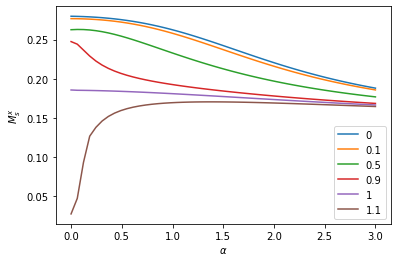

In [7]:
for J3 in J3s:
    plt.plot(alphas, Mxs[J3], label=J3)
plt.legend()
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$M_s^x$')